In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [9]:
# Load and prepare the dataset
file_path = 'VIX0705.csv'  # 替換為你的文件路徑
df = pd.read_csv(file_path,parse_dates=['DATE'])

# Select the relevant columns
selected_columns = ['OPEN', 'HIGH', 'LOW', 'CLOSE']
data = df[selected_columns].values

# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [10]:
def create_dataset_multivariate(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step)])
        dataY.append(dataset[i + time_step, 3])  # 3 corresponds to 'CLOSE'
    return np.array(dataX), np.array(dataY)

In [11]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
# Parameters
time_step = 100
training_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset_multivariate(train_data, time_step)
X_test, y_test = create_dataset_multivariate(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(selected_columns))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(selected_columns))

# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(y_test.shape)

(6815, 100, 4)
[[[0.11169924 0.09885315 0.13520249 0.11012916]
  [0.12459283 0.11069559 0.15       0.12304555]
  [0.1385722  0.12353528 0.16604361 0.13704963]
  ...
  [0.10464169 0.09237098 0.1271028  0.10305914]
  [0.11984256 0.10633259 0.14454829 0.11828688]
  [0.11088491 0.09810521 0.13426791 0.10931339]]

 [[0.12459283 0.11069559 0.15       0.12304555]
  [0.1385722  0.12353528 0.16604361 0.13704963]
  [0.15065147 0.13462977 0.17990654 0.14915024]
  ...
  [0.11984256 0.10633259 0.14454829 0.11828688]
  [0.11088491 0.09810521 0.13426791 0.10931339]
  [0.11794245 0.10458738 0.1423676  0.11638341]]

 [[0.1385722  0.12353528 0.16604361 0.13704963]
  [0.15065147 0.13462977 0.17990654 0.14915024]
  [0.1526873  0.13649963 0.18224299 0.15118967]
  ...
  [0.11088491 0.09810521 0.13426791 0.10931339]
  [0.11794245 0.10458738 0.1423676  0.11638341]
  [0.11278502 0.09985041 0.1364486  0.11121686]]

 ...

 [[0.04845277 0.04088756 0.04626168 0.03263086]
  [0.04465255 0.04126153 0.04719626 0.03575

In [12]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           11000     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51,451
Trainable params: 51,451
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 50,batch_size = 64,verbose = 1)

Epoch 1/50
107/107 [==============================] - 66s 384ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 2/50
107/107 [==============================] - 34s 320ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 3/50
107/107 [==============================] - 35s 325ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/50
107/107 [==============================] - 35s 324ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 5/50
107/107 [==============================] - 35s 325ms/step - loss: 8.5288e-04 - val_loss: 0.0013
Epoch 6/50
107/107 [==============================] - 35s 327ms/step - loss: 7.4536e-04 - val_loss: 0.0011
Epoch 7/50
107/107 [==============================] - 35s 325ms/step - loss: 6.5519e-04 - val_loss: 0.0010
Epoch 8/50
107/107 [==============================] - 35s 323ms/step - loss: 6.0376e-04 - val_loss: 9.4829e-04
Epoch 9/50
107/107 [==============================] - 34s 322ms/step - loss: 5.4540e-04 - val_loss: 9.8776e-04
Epoch 10/50
107/107 [========================

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Evaluate the model on the test data
predictions = model.predict(X_test)

# To inverse transform y_test and predictions, we need to rescale them individually
# Create a new scaler for just the CLOSE values
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(train_data[:, 3].reshape(-1, 1))

# Inverse transform the predictions and true values to the original scale
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
predictions_inv = scaler_y.inverse_transform(predictions)

# Calculate the metrics
mse = mean_squared_error(y_test_inv, predictions_inv)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_inv, predictions_inv)
mape = np.mean(np.abs((y_test_inv - predictions_inv) / y_test_inv)) * 100
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

51/51 [==============================] - 2s 16ms/step
MSE: 0.0007428156280649843
RMSE: 0.027254644155904593
MAE: 0.016421460157097265
MAPE: 13.522755516113644


51/51 [==============================] - 1s 16ms/step


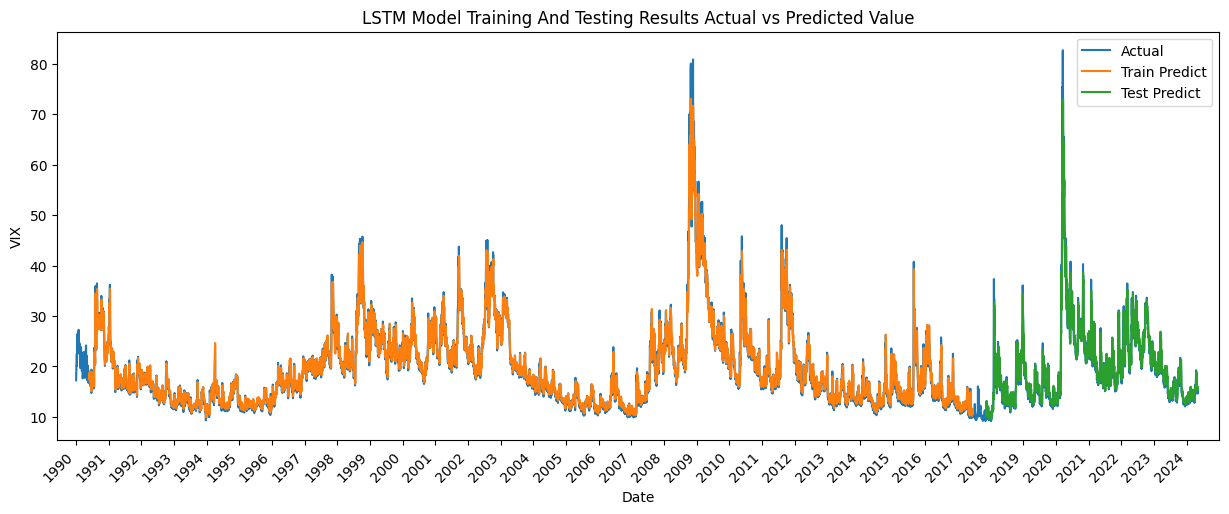

In [17]:
import matplotlib.dates as mdates
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit_transform(data[:, 3].reshape(-1, 1))  # 3 corresponds to 'CLOSE'
# 進行預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict2 = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 3))), axis=1))[:,0]
test_predict2 = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 3))), axis=1))[:,0]

# 準備繪圖數據
train_true = scaler.inverse_transform(train_data)[:, -1]
test_true = scaler.inverse_transform(test_data)[:, -1]

# 移動預測數據以進行繪圖
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict2)+time_step, -1] = train_predict2

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict2)+(time_step*2)+1:len(data)-1, -1] = test_predict2

# 準備繪圖數據，將預測值放回原始數據範圍
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict)+time_step, -1] = scaler_y.inverse_transform(
    np.concatenate((np.zeros((train_predict.shape[0], 3)), train_predict), axis=1))[:, -1]

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_step*2)+1:len(data)-1, -1] = scaler_y.inverse_transform(
    np.concatenate((np.zeros((test_predict.shape[0], 3)), test_predict), axis=1))[:, -1]



# 繪製圖表
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], data[:, 3], label='Actual')
plt.plot(df['DATE'], train_predict_plot[:, -1], label='Train Predict')
plt.plot(df['DATE'], test_predict_plot[:, -1], label='Test Predict')

# 設置x軸格式顯示年份並設置範圍
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([pd.Timestamp('1989-06-01'), pd.Timestamp('2024-12-31')])

# 旋轉x軸標籤以提高可讀性
plt.gcf().autofmt_xdate(rotation=45)

plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('LSTM Model Training And Testing Results Actual vs Predicted Value')
plt.legend()
plt.show()

51/51 [==============================] - 1s 16ms/step


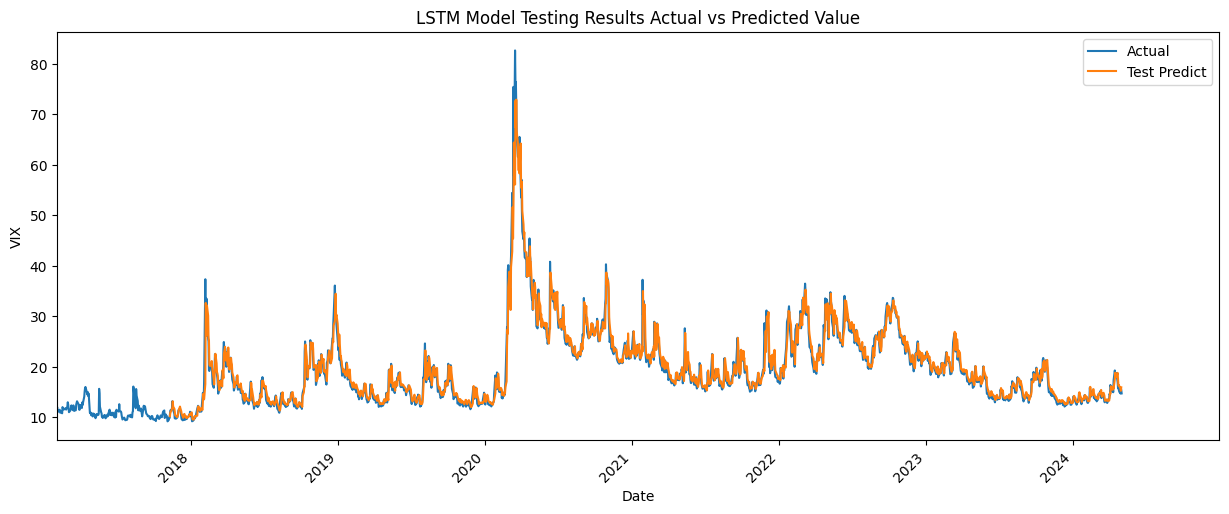

In [18]:
import matplotlib.dates as mdates
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit_transform(data[:, 3].reshape(-1, 1))  # 3 corresponds to 'CLOSE'
# 進行預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict2 = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 3))), axis=1))[:,0]
test_predict2 = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 3))), axis=1))[:,0]

# 準備繪圖數據
train_true = scaler.inverse_transform(train_data)[:, -1]
test_true = scaler.inverse_transform(test_data)[:, -1]

# 移動預測數據以進行繪圖
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict2)+time_step, -1] = train_predict2

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict2)+(time_step*2)+1:len(data)-1, -1] = test_predict2

# 準備繪圖數據，將預測值放回原始數據範圍
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict)+time_step, -1] = scaler_y.inverse_transform(
    np.concatenate((np.zeros((train_predict.shape[0], 3)), train_predict), axis=1))[:, -1]

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_step*2)+1:len(data)-1, -1] = scaler_y.inverse_transform(
    np.concatenate((np.zeros((test_predict.shape[0], 3)), test_predict), axis=1))[:, -1]



# 繪製圖表
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], data[:, 3], label='Actual')
plt.plot(df['DATE'], test_predict_plot[:, -1], label='Test Predict')

# 設置x軸格式顯示年份並設置範圍
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([pd.Timestamp('2017-02-01'), pd.Timestamp('2024-12-31')])

# 旋轉x軸標籤以提高可讀性
plt.gcf().autofmt_xdate(rotation=45)

plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('LSTM Model Testing Results Actual vs Predicted Value')
plt.legend()
plt.show()

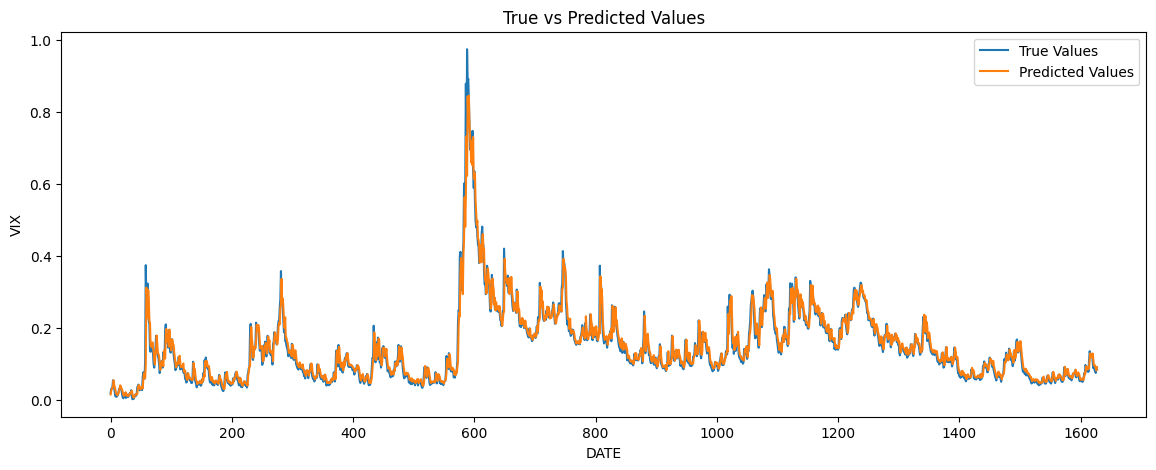

In [19]:

# Optionally, plot the results for better visualization
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='True Values')
plt.plot(predictions_inv, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('DATE')
plt.ylabel('VIX')
plt.legend()
plt.show()

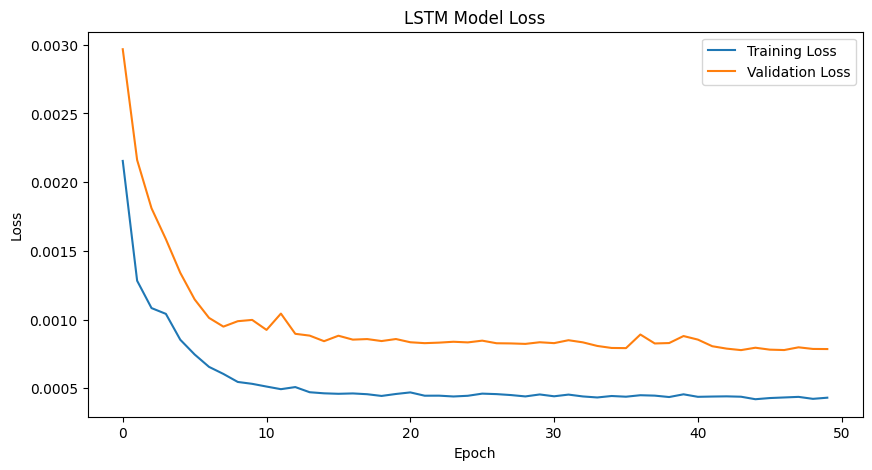

In [20]:
# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [21]:
# 儲存模型參數
model.save('stock_price_prediction_model_0709_lstm.h5')

In [22]:
# 訓練過程中的損失值
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# 輸出最高和最低的損失值
print("Highest Training Loss: ", max(training_loss))
print("Lowest Training Loss: ", min(training_loss))
print("Highest Validation Loss: ", max(validation_loss))
print("Lowest Validation Loss: ", min(validation_loss))

Highest Training Loss:  0.002154693240299821
Lowest Training Loss:  0.00041964606498368084
Highest Validation Loss:  0.0029680049046874046
Lowest Validation Loss:  0.0007772182580083609
